<a href="https://colab.research.google.com/github/rsbaye/Data-Science-Projects/blob/main/Microsimulation_of_Ozempic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn style for better visuals
sns.set(style="whitegrid")


In [47]:

class Person:
    def __init__(self, age, sex, bmi, diet_score, physical_activity, on_ozempic=False):
        self.age = age
        self.sex = sex
        self.bmi = bmi
        self.diet_score = diet_score
        self.physical_activity = physical_activity
        self.on_ozempic = on_ozempic
        self.diabetes = False

    def age_up(self):
        self.age += 1

    def update_bmi(self):
        # Base BMI change based on diet and physical activity
        bmi_change = (self.diet_score - 5) * 0.1 + (self.physical_activity - 2) * -0.2

        # Additional weight loss if on Ozempic
        if self.on_ozempic:
            ozempic_effect = -0.1 * self.bmi  # Approx. 10% weight loss per year
            bmi_change += ozempic_effect

        self.bmi += bmi_change + np.random.normal(0, 0.5)  # Add randomness

    def check_diabetes(self):
        # Simplified diabetes check based on BMI
        if self.bmi > 30 and not self.diabetes:
            self.diabetes = np.random.random() < 0.05  # 5% chance of developing diabetes if obese


def create_population(n):
    return [Person(
        age=np.random.randint(18, 80),
        sex=np.random.choice(['M', 'F']),
        bmi=np.random.normal(25, 3),
        diet_score=np.random.randint(1, 11),
        physical_activity=np.random.randint(1, 5),
        on_ozempic=np.random.choice([True, False], p=[0.2, 0.8])  # Assume 20% of population uses Ozempic
    ) for _ in range(n)]


def run_simulation(population, years):
    results = []
    for year in range(years + 1):  # Include Year 0 (initial state)
        for person in population:
            if year > 0:  # Skip updates for Year 0
                person.age_up()
                person.update_bmi()
                person.check_diabetes()

            # Record data for analysis
            results.append({
                "Year": year,
                "Age": person.age,
                "Sex": person.sex,
                "BMI": person.bmi,
                "On_Ozempic": person.on_ozempic,
                "Diabetes": person.diabetes
            })
    return pd.DataFrame(results)


def analyze_results(df):
    print(f"Average BMI: {df['BMI'].mean():.2f}")
    print(f"Obesity prevalence: {(df['BMI'] > 30).mean():.2%}")
    print(f"Diabetes prevalence: {df['Diabetes'].mean():.2%}")
    print(f"Ozempic usage rate: {df['On_Ozempic'].mean():.2%}")


# Visualization Functions

def plot_bmi_trends(df):
    avg_bmi = df.groupby(['Year', 'On_Ozempic'])['BMI'].mean().reset_index()
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=avg_bmi, x='Year', y='BMI', hue='On_Ozempic', palette=['blue', 'orange'])
    plt.title("Average BMI Over Time (Ozempic vs Non-Ozempic)", fontsize=14)
    plt.ylabel("Average BMI")
    plt.xlabel("Year")
    plt.legend(title="On Ozempic")
    plt.show()


def plot_obesity_prevalence(df):
    df['Obese'] = df['BMI'] > 30
    obesity_rate = df.groupby('Year')['Obese'].mean().reset_index()

    plt.figure(figsize=(10, 6))
    sns.barplot(data=obesity_rate, x='Year', y='Obese', color="salmon")
    plt.title("Obesity Prevalence Over Time", fontsize=14)
    plt.ylabel("Obesity Prevalence (%)")
    plt.xlabel("Year")
    plt.show()


def plot_bmi_distribution(df, year):
    subset = df[df['Year'] == year]

    plt.figure(figsize=(10, 6))
    sns.kdeplot(data=subset[subset['On_Ozempic']], x='BMI', fill=True, label="Ozempic Users", color="orange", alpha=0.6)
    sns.kdeplot(data=subset[~subset['On_Ozempic']], x='BMI', fill=True, label="Non-Ozempic Users", color="blue", alpha=0.6)

    plt.title(f"BMI Distribution in Year {year}", fontsize=14)
    plt.xlabel("BMI")
    plt.ylabel("Density")
    plt.legend()
    plt.show()


def plot_diabetes_prevalence(df):
    diabetes_rate = df.groupby(['Year', 'On_Ozempic'])['Diabetes'].mean().reset_index()

    plt.figure(figsize=(10, 6))
    sns.lineplot(data=diabetes_rate, x='Year', y='Diabetes', hue='On_Ozempic', palette=['blue', 'orange'])

    plt.title("Diabetes Prevalence Over Time (Ozempic vs Non-Ozempic)", fontsize=14)
    plt.ylabel("Diabetes Prevalence (%)")
    plt.xlabel("Year")
    plt.legend(title="On Ozempic")
    plt.show()


def plot_cost_effectiveness(df):
    # Example: Assume $500/month cost for Ozempic and $10k/year cost for diabetes treatment.

    df['Ozempic_Cost'] = df['On_Ozempic'] * (500 * 12)  # Annual Ozempic cost per user.

    diabetes_treatment_cost = df[df['Diabetes']]['Year'].value_counts() * 10000

    total_costs = pd.DataFrame({
        "Year": range(df['Year'].max() + 1),
        "Ozempic_Cost": df.groupby('Year')['Ozempic_Cost'].sum(),
        "Diabetes_Treatment_Cost": diabetes_treatment_cost.reindex(range(df['Year'].max() + 1), fill_value=0)
    })

    total_costs["Total_Cost"] = total_costs["Ozempic_Cost"] + total_costs["Diabetes_Treatment_Cost"]

    total_costs.set_index('Year')[["Ozempic_Cost", "Diabetes_Treatment_Cost"]].plot(kind="bar", stacked=True, figsize=(12, 6), color=["orange", "red"])

    plt.title("Cost Analysis of Ozempic and Diabetes Treatment Over Time", fontsize=14)
    plt.ylabel("Total Cost ($)")
    plt.xlabel("Year")



In [40]:
# Simulation Parameters
pop_size = 10000
simulation_years = 10



In [41]:
# Run Simulation
population = create_population(pop_size)
results_df = run_simulation(population, simulation_years)



In [42]:
# Analyze Results and Plot Visualizations
analyze_results(results_df)



Average BMI: 22.87
Obesity prevalence: 6.82%
Diabetes prevalence: 1.33%
Ozempic usage rate: 20.16%


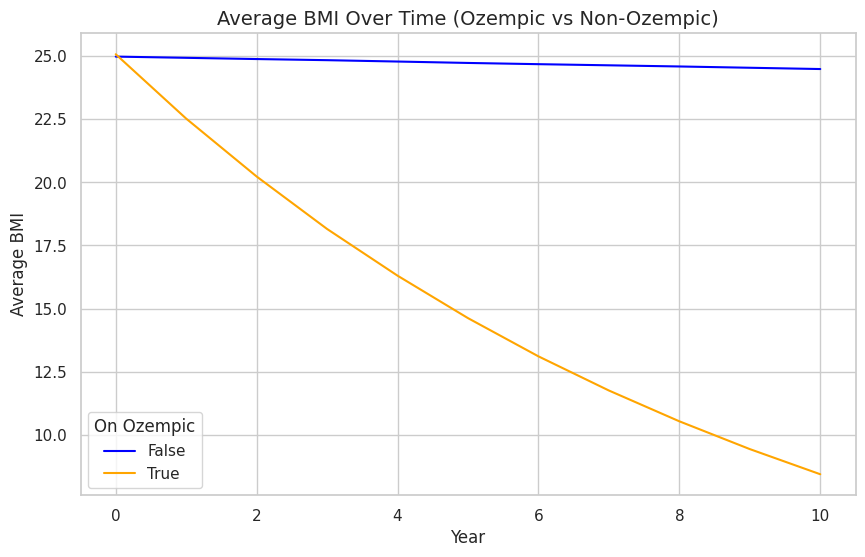

In [43]:
# Visualizations
plot_bmi_trends(results_df)


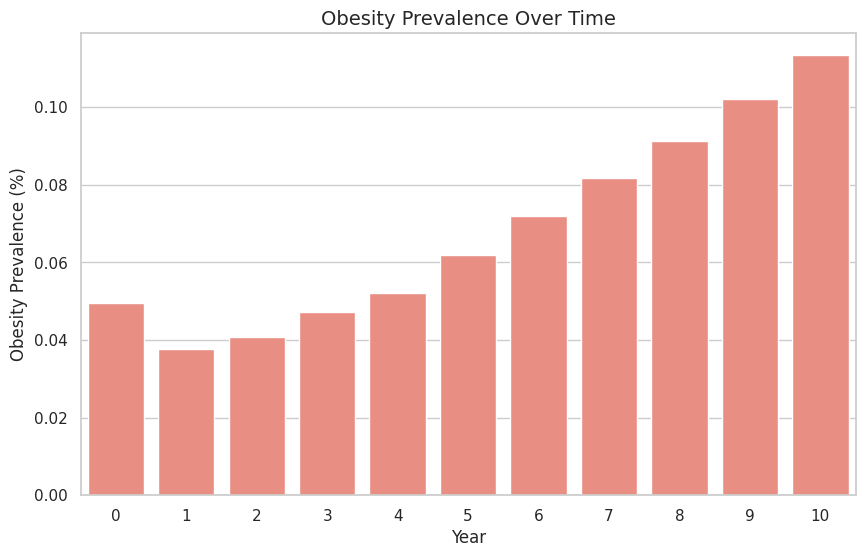

In [44]:
plot_obesity_prevalence(results_df)


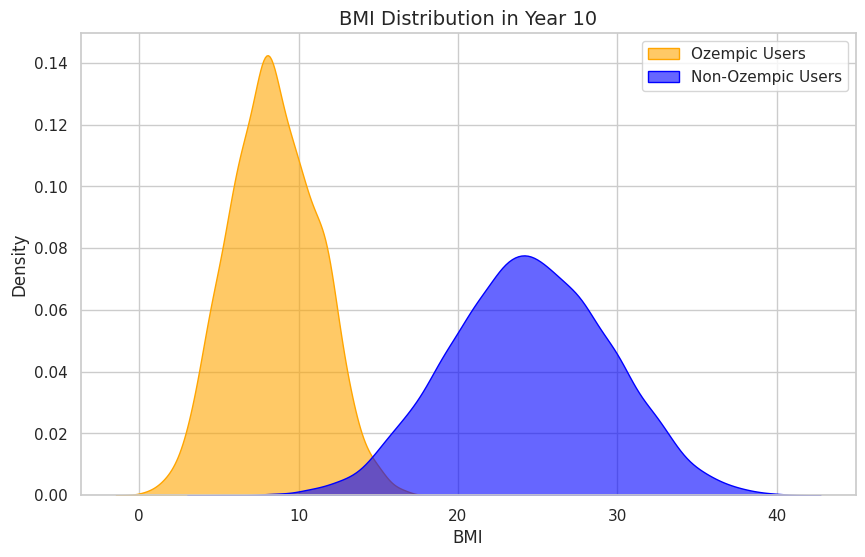

In [45]:
plot_bmi_distribution(results_df, year=simulation_years)   # Final Year Distribution


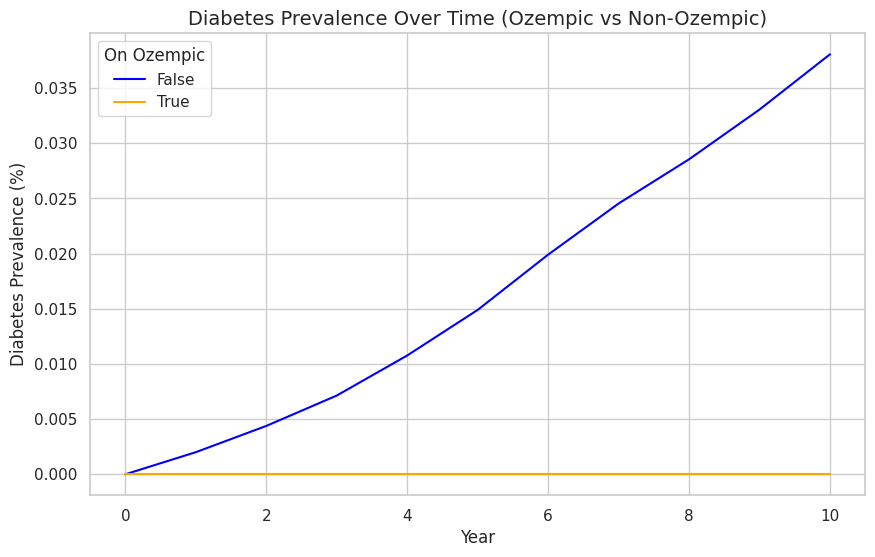

In [48]:
plot_diabetes_prevalence(results_df)


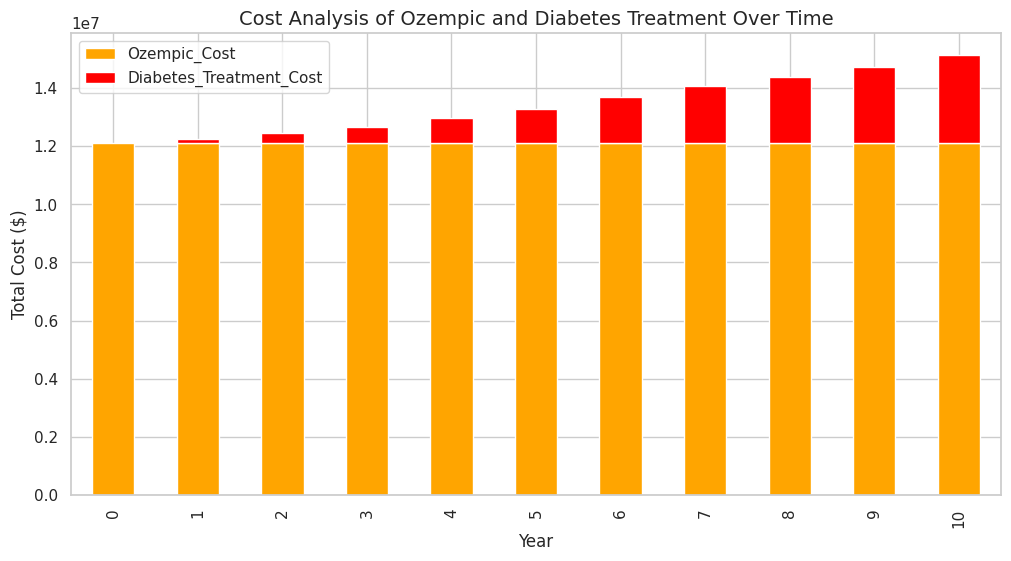

In [49]:
plot_cost_effectiveness(results_df)

In [56]:

# PSA Parameters
n_simulations = 10000
willingness_to_pay_thresholds = np.linspace(0, 200000, 100)

# Example distributions for inputs
ozempic_effectiveness = np.random.normal(-0.1, 0.02, n_simulations)  # Mean = 10% weight loss
ozempic_cost = np.random.normal(6000, 1000, n_simulations)           # Annual cost
diabetes_treatment_cost = np.random.normal(10000, 2000, n_simulations)  # Annual diabetes treatment cost
qaly_gain = np.random.normal(1.5, 0.3, n_simulations)                # QALY gain from intervention

# Calculate ICERs
incremental_costs = ozempic_cost + diabetes_treatment_cost * ozempic_effectiveness
incremental_qalys = qaly_gain
icers = incremental_costs / incremental_qalys



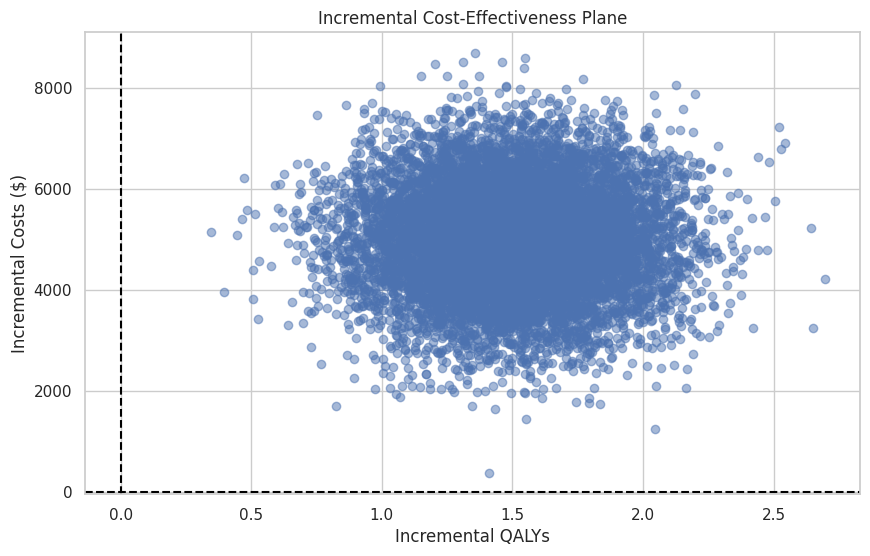

In [55]:
# Generate Incremental Cost-Effectiveness Plane
plt.figure(figsize=(10, 6))
plt.scatter(incremental_qalys, incremental_costs, alpha=0.5)
plt.axhline(0, color='black', linestyle='--')
plt.axvline(0, color='black', linestyle='--')
plt.title("Incremental Cost-Effectiveness Plane")
plt.xlabel("Incremental QALYs")
plt.ylabel("Incremental Costs ($)")
plt.grid(True)
plt.show()


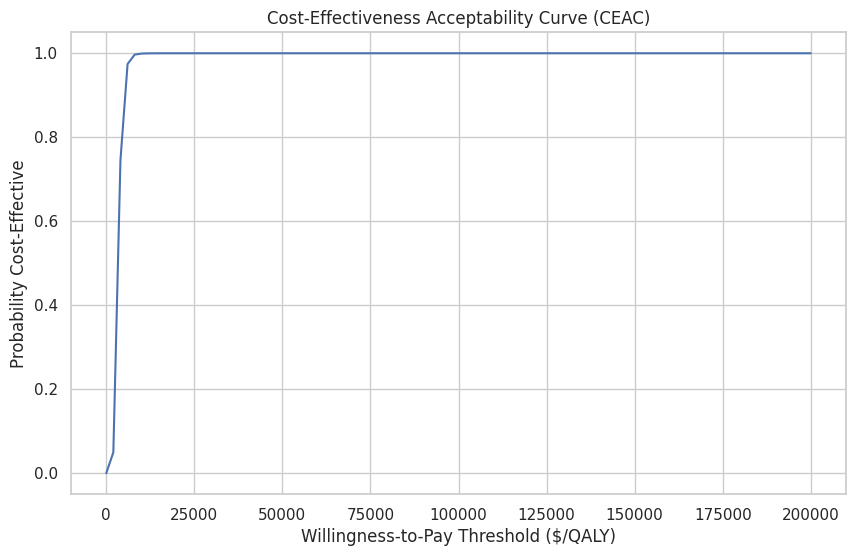

In [54]:
# Generate CEAC
ceac = []
for wtp in willingness_to_pay_thresholds:
    ceac.append((icers <= wtp).mean())

plt.figure(figsize=(10, 6))
plt.plot(willingness_to_pay_thresholds, ceac)
plt.title("Cost-Effectiveness Acceptability Curve (CEAC)")
plt.xlabel("Willingness-to-Pay Threshold ($/QALY)")
plt.ylabel("Probability Cost-Effective")
plt.grid(True)
plt.show()